In [3]:
%cd /om2/vast/cbmm/xboix/src/Robustness

/om2/vast/cbmm/xboix/src/Robustness


In [4]:
experiment_name = "uci"
results_dir = '/vast/robustness/' + experiment_name + '/'

In [5]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.set_context("poster")

import matplotlib.pyplot as plt
import pandas as pd
import pickle 
import os 

import numpy as np
import pandas
    
import runs.config_experiments_uci as run
experiment_list = run.config_experiments(results_dir, create_json=False)

3150 config files created


In [6]:
if not os.path.isfile('/vast/robustness/datasets/UCI/datasets_info.csv'):
    import json
    datasets = []
    for data_set in range(20,66):
        with open('/vast/robustness/configs_datasets/' + str(data_set) + '.json') as config_file:
            config = json.load(config_file)
            tmpX = np.shape(np.genfromtxt('/vast/robustness/datasets/UCI/imp_' + config["name_file"] 
                                 + '_' + "trainX.csv", delimiter=','))
            config["num_examples"] = tmpX[0]
            config["num_features"] = tmpX[1]
            datasets.append(config)
    df = pd.DataFrame(datasets) 
    df.to_csv('/vast/robustness/datasets/UCI/datasets_info.csv')
else:
    df = pd.read_csv('/vast/robustness/datasets/UCI/datasets_info.csv')

name_attacks = ["linf_pgd","l2_pgd", "linf_fgsm", "l2_fgm"]

In [7]:
list(df[(df.num_features>50) & (df.num_examples > 500)].dataset_id)

[20, 24, 35, 36, 61]

In [11]:

list_entries = []
for net in ['OneLayer', 'ThreeLayer']:
    for dataset_id in list(df[(df.num_features>50) & (df.num_examples > 500)].dataset_id):

        for attack in [name_attacks[0]]:

            file_name = results_dir + experiment_list[0]['model_name'] + '/results/acc_' + 'val' + '_' + attack + '.pkl'
            if not os.path.isfile(file_name):
                print("Missing!! " + file_name)
                continue
            with open(file_name, 'rb') as f:
                tmp = pickle.load(f)


            for cv_epsilon in list(tmp.keys()):
                # Hash table of parameters
                parameters = {"epsilon": {}, "backbone": {}, "initial_learning_rate": {}, 
                              "robust_training": {}, "type_robust": {}, "epsilon_pgd_training":{}}

                to_exclude = []
                experiment_list_tmp = [element for i, element in enumerate(experiment_list) if i not in to_exclude]
                for exp in experiment_list_tmp:
                    if not exp['data_set'] == dataset_id: 
                        continue
                    for kk in parameters.keys():
                        if exp[kk] in parameters[kk]:
                            parameters[kk][exp[kk]].append(int(exp["model_name"]))
                        else:
                            parameters[kk][exp[kk]] = [int(exp["model_name"])]


                # For all methods, do cross-val and create an entry of the results
                backbones = [net, net + '+pgd']



                for backbone in backbones:
                    for robust_training in [True, False]:
                        if robust_training:
                            type_robust_trainings = ['l1','linf', "certificate"] 
                        else:
                            type_robust_trainings = ['none']
                        for type_robust in type_robust_trainings:

                            if (backbone == 'Madry' and robust_training == True) or \
                                (backbone == 'CNN+clipping' and robust_training == False):
                                continue

                            if robust_training==False:
                                ids = list(set(parameters["backbone"][backbone]) & 
                                           set(parameters["robust_training"][False]))
                            else:
                                ids = list(set(parameters["backbone"][backbone]) & 
                                       set(parameters["robust_training"][True])&
                                      set(parameters["type_robust"][type_robust]))



                            if backbone == net + '+pgd' and robust_training == True:
                                continue

                            if ids == []:
                                continue
                            #print(ids)


                            # Cross-validation among learning rates and epsilons:
                            best_acc = -1
                            best_id = ids[0]
                            for id in ids:
                                file_name = results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + attack + '.pkl'
                                if not os.path.isfile(file_name):
                                    print("Missing!! " + file_name)
                                    continue

                                with open(file_name, 'rb') as f:
                                    tmp = pickle.load(f)

                                acc = tmp[cv_epsilon]
                                if acc>best_acc:
                                    best_id = id
                                    best_acc = acc

                            if best_acc == -1:
                                continue

                            if (robust_training == False) & (backbone==net):  
                                name_legend = 'vanilla'
                            elif backbone== net + '+pgd':
                                name_legend = 'pgd'
                            else:
                                if type_robust=='certificate':
                                    name_legend = 'RUB'
                                elif type_robust=='linf':
                                    name_legend = 'aRUB_Linf'
                                else:
                                    name_legend = 'aRUB_L1'

                            entry = {"dataset": dataset_id,
                                     "net": net,
                                    "learning_rate": experiment_list[best_id]['initial_learning_rate'],
                                    #"backbone": net, #experiment_list[best_id]['backbone'],
                                    "robust_training": name_legend,
                                    "epsilon": experiment_list[best_id]['epsilon'],
                                    "epsilon_pgd_training": experiment_list[best_id]['epsilon_pgd_training']}

                            dataset = "test"
                            entry["attack"] = attack
                            entry["experiment_id"] = best_id

                            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                                attack + '.pkl', 'rb') as f:
                                tmp = pickle.load(f)

                            entry["test_epsilon"] = cv_epsilon
                            entry["accuracy"] =  100*tmp[cv_epsilon]
                            
                            with open(results_dir + experiment_list[best_id]['model_name'] + 
                                          '/results/training_time.pkl', 'rb') as f:
                                tmp = pickle.load(f)
                                entry["images_per_second"] = np.mean(tmp) 
                                entry["std_images_per_second"] = np.std(tmp) 

                            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + 'test' + '_' + 
                                    'bound' + '.pkl', 'rb') as f:
                                tmp = pickle.load(f)
                            entry["bound"] =  100*tmp[cv_epsilon]
                            
                            list_entries.append(entry.copy())

df_results = pd.DataFrame.from_dict(list_entries) 


In [13]:
df_results.to_csv('UCI_results_old.csv')

In [12]:
df_results

,dataset,net,learning_rate,robust_training,epsilon,epsilon_pgd_training,attack,experiment_id,test_epsilon,accuracy,images_per_second,std_images_per_second,bound
0,20,OneLayer,0.0100,aRUB_L1,0.0001,0.1,linf_pgd,1681,0.0,100.000000,4359.108583,163.516801,100.000000
1,20,OneLayer,0.0100,aRUB_Linf,0.0001,0.1,linf_pgd,1604,0.0,100.000000,3131.178596,19.854361,100.000000
2,20,OneLayer,1.0000,RUB,0.1000,0.1,linf_pgd,1817,0.0,99.414062,43437.593843,8976.725267,99.414062
3,20,OneLayer,0.1000,vanilla,0.1000,0.1,linf_pgd,1576,0.0,99.609375,244323.444365,22837.826645,99.609375
4,20,OneLayer,1.0000,pgd,10.0000,0.3,linf_pgd,1741,0.0,100.000000,2041.764916,4.406258,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,61,ThreeLayer,0.0100,aRUB_L1,0.0100,0.1,linf_pgd,1369,1.0,34.785979,2724.818403,31.153834,22.734375
646,61,ThreeLayer,0.0001,aRUB_Linf,1.0000,0.1,linf_pgd,1318,1.0,29.291587,3962.197895,55.883147,22.734375
647,61,ThreeLayer,0.1000,RUB,0.0100,0.1,linf_pgd,1512,1.0,53.319015,765.542920,15.051587,22.734375
648,61,ThreeLayer,0.1000,vanilla,0.1000,0.1,linf_pgd,1261,1.0,21.594129,181246.221852,16221.927455,22.734375


In [15]:
for dataset_id in list(df[(df.num_features>50) & (df.num_examples > 500)].dataset_id):
    print(dataset_id)
    print("-----------------------------------------")
    
    for net in ['OneLayer', 'ThreeLayer']:

        ss = df_results[(df_results.net == net) & (df_results.dataset == dataset_id) & (df_results.attack == 'linf_pgd')].pivot(index=['robust_training'], columns=['test_epsilon'], values=['bound'])
        display(ss)

20
-----------------------------------------


bound                                                \
test_epsilon         0.0000      0.0002      0.0005     0.0008     0.0010   
robust_training                                                             
RUB               99.414062   99.414062   99.414062  99.414062  99.414062   
aRUB_L1          100.000000  100.000000  100.000000  99.804688  99.804688   
aRUB_Linf        100.000000  100.000000  100.000000  99.804688  99.804688   
pgd              100.000000  100.000000   99.804688  99.804688  99.218750   
vanilla           99.609375   99.609375  100.000000  99.804688  99.804688   

                                                                           \
test_epsilon        0.0015     0.0020     0.0030     0.0100 0.1000 0.3000   
robust_training                                                             
RUB              99.414062  97.851562  75.625000  13.476562    0.0    0.0   
aRUB_L1          99.609375  99.414062  86.796875  15.234375    0.0    0.0   
aRUB_Linf        99.609375  99.414062  86.796875  15.234375    0.0    0.0   
pgd              93.750000  76.640625  43.085938   0.781250    0.0    0.0   
vanilla          99.609375  99.414062  86.796875  15.234375    0.0    0.0   

                               
test_epsilon    0.5000 1.0000  
robust_training                
RUB                0.0    0.0  
aRUB_L1            0.0    0.0  
aRUB_Linf          0.0    0.0  
pgd                0.0    0.0  
vanilla            0.0    0.0

bound                                                  \
test_epsilon    0.0000 0.0002 0.0005      0.0008     0.0010     0.0015   
robust_training                                                          
RUB              100.0  100.0  100.0   99.804688  99.023438  87.382812   
aRUB_L1          100.0  100.0  100.0  100.000000  99.804688  97.460938   
aRUB_Linf        100.0  100.0  100.0   99.218750  98.437500  94.492188   
pgd              100.0  100.0  100.0   99.804688  99.218750  98.046875   
vanilla          100.0  100.0  100.0  100.000000  99.609375  96.484375   

                                                                             
test_epsilon        0.0020     0.0030    0.0100 0.1000 0.3000 0.5000 1.0000  
robust_training                                                              
RUB              74.023438  49.023438  6.367188    0.0    0.0    0.0    0.0  
aRUB_L1          79.687500  28.281250  0.000000    0.0    0.0    0.0    0.0  
aRUB_Linf        78.632812  41.132812  0.195312    0.0    0.0    0.0    0.0  
pgd              90.976562  60.429687  0.390625    0.0    0.0    0.0    0.0  
vanilla          88.437500  52.265625  0.585938    0.0    0.0    0.0    0.0

24
-----------------------------------------


bound                                              \
test_epsilon        0.0000     0.0002     0.0005     0.0008     0.0010   
robust_training                                                          
RUB              98.437500  98.320312  98.046875  97.890625  97.773438   
aRUB_L1          98.906250  98.789062  98.515625  98.515625  98.242188   
aRUB_Linf        99.648438  99.414062  99.296875  98.515625  98.398438   
pgd              99.531250  99.531250  99.179688  98.750000  98.359375   
vanilla          98.164062  97.500000  97.187500  96.640625  96.406250   

                                                                           \
test_epsilon        0.0015     0.0020     0.0030     0.0100 0.1000 0.3000   
robust_training                                                             
RUB              97.851562  97.578125  94.140625  51.250000    0.0    0.0   
aRUB_L1          97.851562  97.500000  96.093750  10.703125    0.0    0.0   
aRUB_Linf        95.351562  76.171875  18.789062   0.000000    0.0    0.0   
pgd              97.226562  92.148438  50.312500   0.000000    0.0    0.0   
vanilla          95.195312  91.601562  73.515625   2.109375    0.0    0.0   

                               
test_epsilon    0.5000 1.0000  
robust_training                
RUB                0.0    0.0  
aRUB_L1            0.0    0.0  
aRUB_Linf          0.0    0.0  
pgd                0.0    0.0  
vanilla            0.0    0.0

bound                                              \
test_epsilon        0.0000     0.0002     0.0005     0.0008     0.0010   
robust_training                                                          
RUB              98.789062  98.789062  98.515625  98.125000  98.125000   
aRUB_L1          98.593750  98.593750  98.281250  97.304688  96.718750   
aRUB_Linf        99.531250  99.531250  98.789062  97.539062  94.726562   
pgd              99.531250  99.531250  99.414062  98.437500  97.421875   
vanilla          98.242188  98.125000  97.460938  96.523438  96.132812   

                                                                           \
test_epsilon        0.0015     0.0020     0.0030     0.0100 0.1000 0.3000   
robust_training                                                             
RUB              97.695312  97.070312  95.390625  10.000000    0.0    0.0   
aRUB_L1          89.648438  76.484375  27.929688   0.234375    0.0    0.0   
aRUB_Linf        40.781250   4.257812   0.117188   0.000000    0.0    0.0   
pgd              86.953125  58.632812   6.445312   0.000000    0.0    0.0   
vanilla          91.210938  74.531250  18.906250   0.234375    0.0    0.0   

                               
test_epsilon    0.5000 1.0000  
robust_training                
RUB                0.0    0.0  
aRUB_L1            0.0    0.0  
aRUB_Linf          0.0    0.0  
pgd                0.0    0.0  
vanilla            0.0    0.0

35
-----------------------------------------


bound                                                  \
test_epsilon         0.0000      0.0002      0.0005      0.0008      0.0010   
robust_training                                                               
RUB               99.921875   99.921875   99.921875   99.804688   99.726562   
aRUB_L1           99.882812   99.804688   99.687500   99.687500   99.453125   
aRUB_Linf        100.000000  100.000000  100.000000  100.000000  100.000000   
pgd              100.000000  100.000000  100.000000  100.000000  100.000000   
vanilla           99.882812   99.804688   99.687500   99.687500   99.453125   

                                                                          \
test_epsilon        0.0015     0.0020     0.0030    0.0100 0.1000 0.3000   
robust_training                                                            
RUB              99.609375  97.148438  28.867188  0.898437    0.0    0.0   
aRUB_L1          98.945312  96.796875  62.304688  2.500000    0.0    0.0   
aRUB_Linf        99.765625  99.648438  12.343750  0.000000    0.0    0.0   
pgd              99.882812  68.085938   4.531250  0.000000    0.0    0.0   
vanilla          98.945312  96.796875  62.382812  2.500000    0.0    0.0   

                               
test_epsilon    0.5000 1.0000  
robust_training                
RUB                0.0    0.0  
aRUB_L1            0.0    0.0  
aRUB_Linf          0.0    0.0  
pgd                0.0    0.0  
vanilla            0.0    0.0

bound                                               \
test_epsilon    0.0000      0.0002     0.0005     0.0008     0.0010   
robust_training                                                       
RUB              100.0  100.000000  99.882812  99.570312  99.375000   
aRUB_L1          100.0  100.000000  99.882812  99.570312  99.257812   
aRUB_Linf        100.0  100.000000  99.882812  99.570312  99.257812   
pgd              100.0   99.882812  99.882812  99.882812  99.765625   
vanilla          100.0  100.000000  99.882812  99.570312  99.257812   

                                                                          \
test_epsilon        0.0015     0.0020     0.0030    0.0100 0.1000 0.3000   
robust_training                                                            
RUB              75.000000  41.992188  15.468750  0.195312    0.0    0.0   
aRUB_L1          75.781250  41.484375  16.210938  0.195312    0.0    0.0   
aRUB_Linf        75.546875  41.367188  16.210938  0.195312    0.0    0.0   
pgd              99.648438  60.820312   3.007812  0.000000    0.0    0.0   
vanilla          75.781250  41.484375  16.210938  0.195312    0.0    0.0   

                               
test_epsilon    0.5000 1.0000  
robust_training                
RUB                0.0    0.0  
aRUB_L1            0.0    0.0  
aRUB_Linf          0.0    0.0  
pgd                0.0    0.0  
vanilla            0.0    0.0

36
-----------------------------------------


bound                                                 \
test_epsilon         0.0000      0.0002      0.0005      0.0008     0.0010   
robust_training                                                              
RUB               99.804688   99.804688   99.804688   99.804688  99.804688   
aRUB_L1           99.804688   99.804688   99.804688   99.804688  99.804688   
aRUB_Linf         99.804688   99.804688   99.804688   99.804688  99.804688   
pgd              100.000000  100.000000  100.000000  100.000000  99.804688   
vanilla           99.804688   99.804688   99.804688   99.804688  99.414062   

                                                                           \
test_epsilon        0.0015     0.0020     0.0030     0.0100 0.1000 0.3000   
robust_training                                                             
RUB              99.179688  98.007812  83.281250  30.273438    0.0    0.0   
aRUB_L1          99.804688  99.804688  98.046875  30.117187    0.0    0.0   
aRUB_Linf        99.804688  99.804688  99.414062  25.429687    0.0    0.0   
pgd              96.210938  86.679688  52.890625   3.125000    0.0    0.0   
vanilla          97.851562  93.906250  82.343750  36.835938    0.0    0.0   

                               
test_epsilon    0.5000 1.0000  
robust_training                
RUB                0.0    0.0  
aRUB_L1            0.0    0.0  
aRUB_Linf          0.0    0.0  
pgd                0.0    0.0  
vanilla            0.0    0.0

bound                                                  \
test_epsilon         0.0000      0.0002      0.0005      0.0008      0.0010   
robust_training                                                               
RUB               99.804688   99.804688   99.804688   99.804688   99.414062   
aRUB_L1          100.000000  100.000000  100.000000  100.000000  100.000000   
aRUB_Linf        100.000000  100.000000  100.000000  100.000000  100.000000   
pgd              100.000000  100.000000  100.000000   99.804688   99.804688   
vanilla          100.000000  100.000000  100.000000  100.000000  100.000000   

                                                                           \
test_epsilon        0.0015     0.0020     0.0030     0.0100 0.1000 0.3000   
robust_training                                                             
RUB              98.828125  96.250000  88.085938  33.789062    0.0    0.0   
aRUB_L1          99.218750  95.273438  82.226562   7.539062    0.0    0.0   
aRUB_Linf        99.218750  95.273438  82.421875   7.734375    0.0    0.0   
pgd              99.609375  93.398438  46.601562   0.000000    0.0    0.0   
vanilla          99.218750  95.273438  81.835938   7.734375    0.0    0.0   

                               
test_epsilon    0.5000 1.0000  
robust_training                
RUB                0.0    0.0  
aRUB_L1            0.0    0.0  
aRUB_Linf          0.0    0.0  
pgd                0.0    0.0  
vanilla            0.0    0.0

61
-----------------------------------------


bound                                              \
test_epsilon        0.0000     0.0002     0.0005     0.0008     0.0010   
robust_training                                                          
RUB              94.453125  65.312500  26.015625  22.734375  22.734375   
aRUB_L1          94.453125  54.179687  22.734375  22.734375  22.734375   
aRUB_Linf        95.390625  52.812500  22.734375  22.734375  22.734375   
pgd              94.921875  34.335938  22.734375  22.734375  22.734375   
vanilla          94.453125  58.789062  22.734375  22.734375  22.734375   

                                                                        \
test_epsilon        0.0015     0.0020     0.0030     0.0100     0.1000   
robust_training                                                          
RUB              22.734375  22.734375  22.734375  22.734375  22.734375   
aRUB_L1          22.734375  22.734375  22.734375  22.734375  22.734375   
aRUB_Linf        22.734375  22.734375  22.734375  22.734375  22.734375   
pgd              22.734375  22.734375  22.734375  22.734375  22.734375   
vanilla          22.734375  22.734375  22.734375  22.734375  22.734375   

                                                  
test_epsilon        0.3000     0.5000     1.0000  
robust_training                                   
RUB              22.734375  22.734375  22.734375  
aRUB_L1          22.734375  22.734375  22.734375  
aRUB_Linf        22.734375  22.734375  22.734375  
pgd              22.734375  22.734375  22.734375  
vanilla          22.734375  22.734375  22.734375

bound                                              \
test_epsilon        0.0000     0.0002     0.0005     0.0008     0.0010   
robust_training                                                          
RUB              95.351562  67.656250  27.421875  23.671875  22.734375   
aRUB_L1          94.921875  64.882812  26.445312  23.203125  22.734375   
aRUB_Linf        95.859375  22.734375  22.734375  22.734375  22.734375   
pgd              95.390625  22.734375  22.734375  22.734375  22.734375   
vanilla          94.921875  65.820312  26.445312  23.203125  22.734375   

                                                                        \
test_epsilon        0.0015     0.0020     0.0030     0.0100     0.1000   
robust_training                                                          
RUB              22.734375  22.734375  22.734375  22.734375  22.734375   
aRUB_L1          22.734375  22.734375  22.734375  22.734375  22.734375   
aRUB_Linf        22.734375  22.734375  22.734375  22.734375  22.734375   
pgd              22.734375  22.734375  22.734375  22.734375  22.734375   
vanilla          22.734375  22.734375  22.734375  22.734375  22.734375   

                                                  
test_epsilon        0.3000     0.5000     1.0000  
robust_training                                   
RUB              22.734375  22.734375  22.734375  
aRUB_L1          22.734375  22.734375  22.734375  
aRUB_Linf        22.734375  22.734375  22.734375  
pgd              22.734375  22.734375  22.734375  
vanilla          22.734375  22.734375  22.734375

In [44]:
df_final = df_results.groupby(['backbone', 'robust_training', 'dataset','test_epsilon']).mean().reset_index()

df_final["winner"] = False
df_final["tie"] = False
df_final["accuracy_normal"] = 0
for attack in [name_attacks[0]]:
    list(set(df_final.test_epsilon))
    for cv_epsilon in list(set(df_final.test_epsilon)):
        for idx_dd in range(0,46):
            xx = df_final[(df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon)]
            df_final.loc[(df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon),
                         "accuracy_normal"] = xx.accuracy / xx.accuracy.max()
            winners = df_final[ (df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon)
                               & (df_final.accuracy_normal >= 0.95)]
            if len(winners)==1:    
                df_final.loc[(df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon) & (df_final.accuracy_normal==1), "winner"] = True
            else:
                df_final.loc[(df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon) & (df_final.accuracy_normal >=  0.95), "tie"] = True

win_pgd = list(df_final[(df_final.backbone=='MLP+pgd') & (df_final.robust_training == False) & (df_final.winner)].dataset)
win_robust = list(df_final[(df_final.backbone=='MLP') & (df_final.robust_training == True) & (df_final.winner)].dataset)

#winner_pgd_list.append(win_pgd)
#winner_robust_list.append(win_robust)

[[], [], [34], [9, 31], [], [11], [11, 43], [9], [12, 23], [9, 23, 41], [9, 23, 41], [], []]
[[45], [43], [45], [45], [31, 41, 45], [8, 9, 30, 31, 41, 45], [8, 9, 13, 30, 31, 34, 41], [8, 11, 12, 18, 21, 25, 30, 32, 34, 36, 41, 43], [8, 11, 32, 43], [8, 11, 32, 43], [8, 32, 43], [8, 11, 12, 23, 32, 43], [11, 32, 34, 41, 43]]


In [58]:

win_pgd = []
win_robust = []

df_final = df_results.groupby(['backbone', 'robust_training', 'dataset','test_epsilon']).mean().reset_index()

df_final["winner"] = False
df_final["tie"] = False
df_final["accuracy_normal"] = 0
for attack in [name_attacks[0]]:
    list(set(df_final.test_epsilon))
    for cv_epsilon in list(set(df_final.test_epsilon)):
        for idx_dd in range(0,46):
            xx = df_final[(df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon)]
            df_final.loc[(df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon),
                         "accuracy_normal"] = xx.accuracy / xx.accuracy.max()
            winners = df_final[ (df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon)
                               & (df_final.accuracy_normal >= 0.95)]
            if len(winners)==1:    
                df_final.loc[(df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon) & (df_final.accuracy_normal==1), "winner"] = True
            else:
                df_final.loc[(df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon) & (df_final.accuracy_normal >=  0.95), "tie"] = True

        win_pgd.append(list(df_final[(df_final.backbone=='MLP+pgd') & (df_final.robust_training == False)&(df_final.test_epsilon==cv_epsilon)
                                     & (df_final.winner)].dataset))
        win_robust.append(list(df_final[(df_final.backbone=='MLP') & (df_final.robust_training == True)&(df_final.test_epsilon==cv_epsilon)
                                        & (df_final.winner)].dataset))

#winner_pgd_list.append(win_pgd)
#winner_robust_list.append(win_robust)

In [59]:
win_robust

[[45],
 [8, 11, 32, 43],
 [8, 32, 43],
 [8, 11, 12, 23, 32, 43],
 [11, 32, 34, 41, 43],
 [45],
 [8, 11, 32, 43],
 [43],
 [8, 11, 12, 18, 21, 25, 30, 32, 34, 36, 41, 43],
 [8, 9, 13, 30, 31, 34, 41],
 [8, 9, 30, 31, 41, 45],
 [31, 41, 45],
 [45]]

In [60]:
win_pgd

[[],
 [9, 23, 41],
 [9, 23, 41],
 [],
 [],
 [9, 31],
 [12, 23],
 [],
 [9],
 [11, 43],
 [11],
 [],
 [34]]

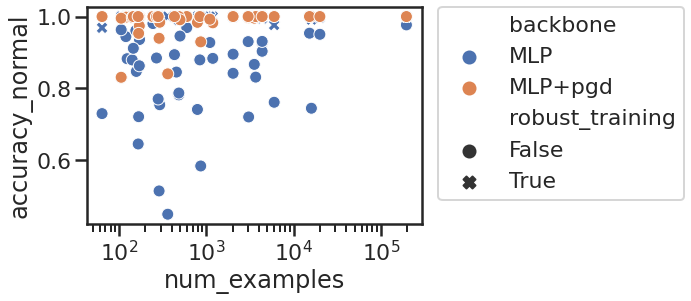

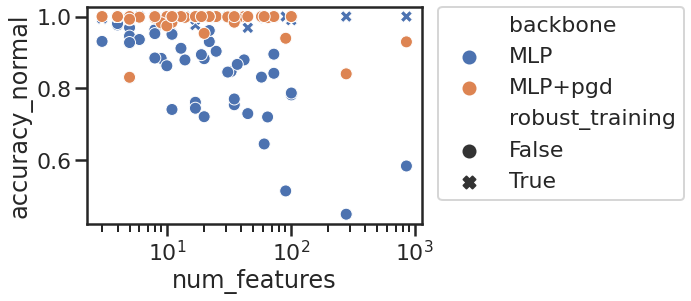

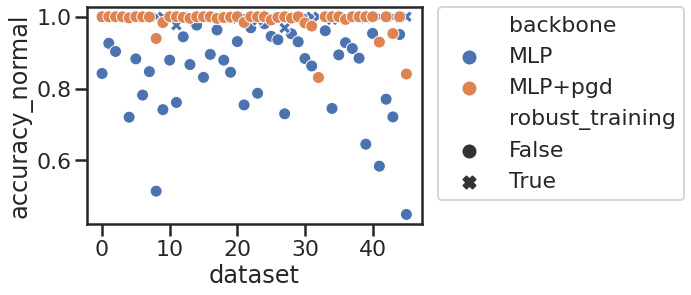

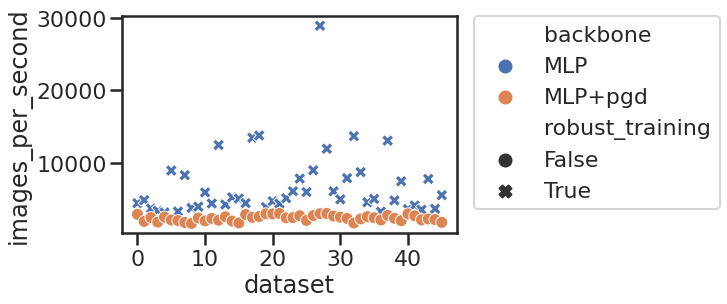

In [42]:
df_final = df_results.groupby(['backbone', 'robust_training', 'dataset']).mean().reset_index()
for idx_dd in range(0,46):
    xx = df_final[df_final.dataset == idx_dd]
    df_final.loc[df_final.dataset == idx_dd, "accuracy_normal"] = xx.accuracy / xx.accuracy.max()

        
plt.figure()
sns.scatterplot(data=df_final, x="num_examples",y="accuracy_normal",hue="backbone",style="robust_training")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xscale('log')

plt.figure()
sns.scatterplot(data=df_final, x="num_features",y="accuracy_normal",hue="backbone",style="robust_training")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xscale('log')

plt.figure()
sns.scatterplot(data=df_final, x="dataset",y="accuracy_normal",hue="backbone",style="robust_training")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure()
sns.scatterplot(data=df_final[~((df_final.robust_training==False)&(df_final.backbone=='MLP'))], 
                x="dataset",y="images_per_second",hue="backbone",style="robust_training")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


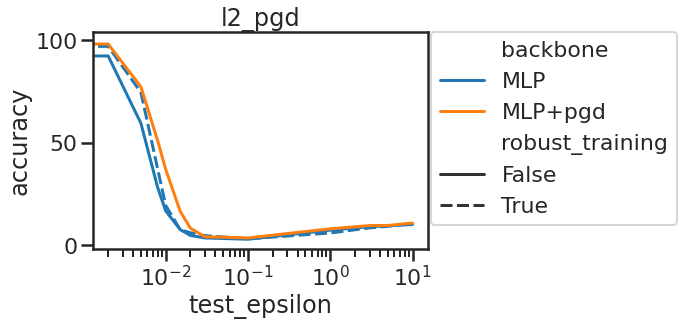

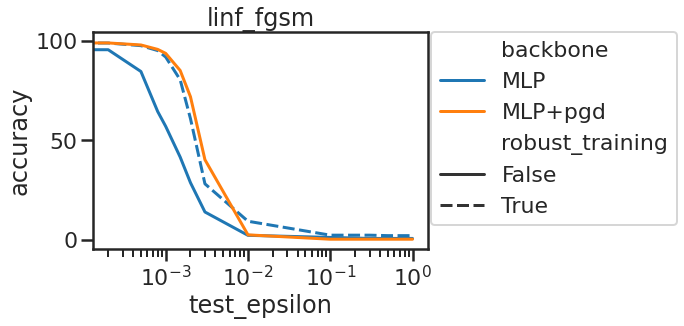

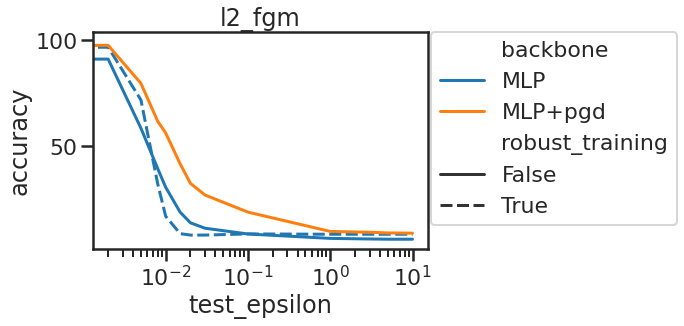

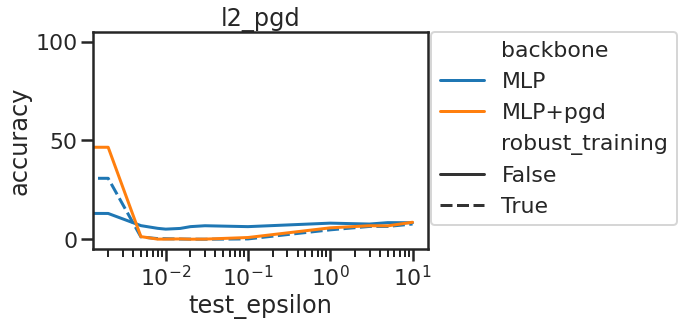

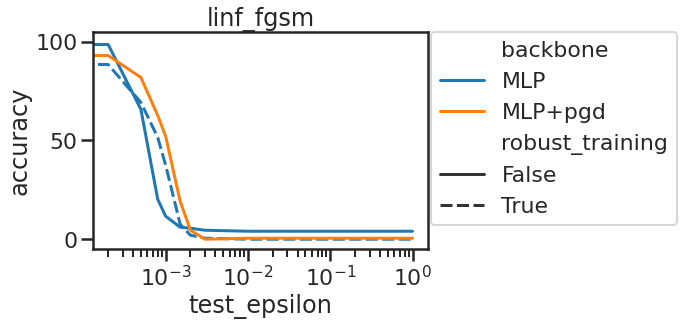

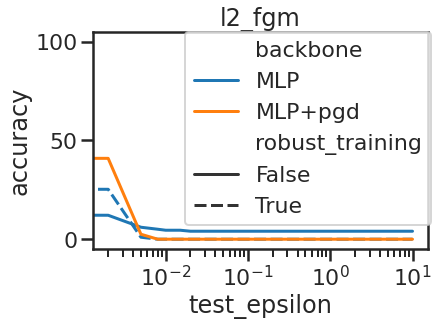

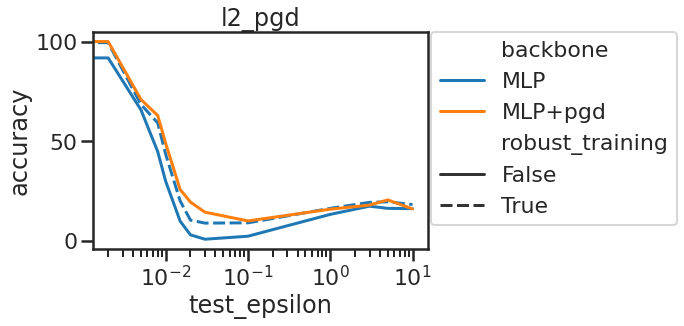

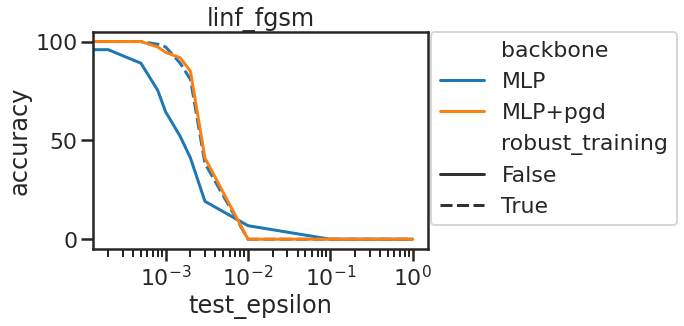

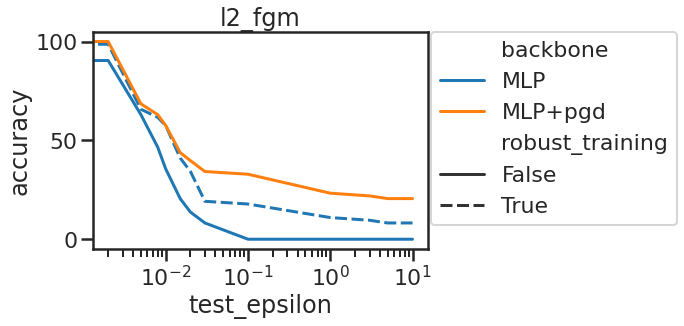

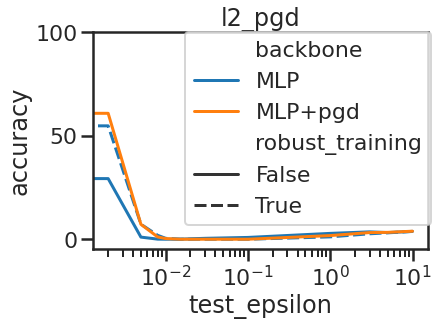

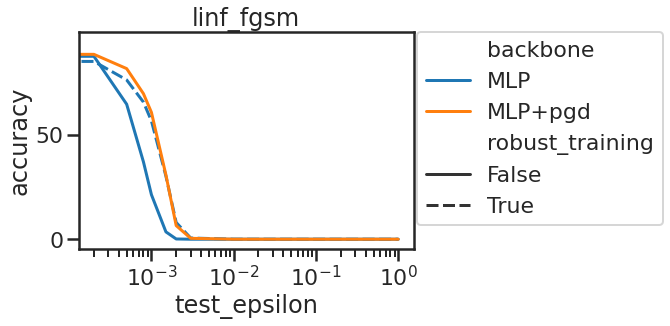

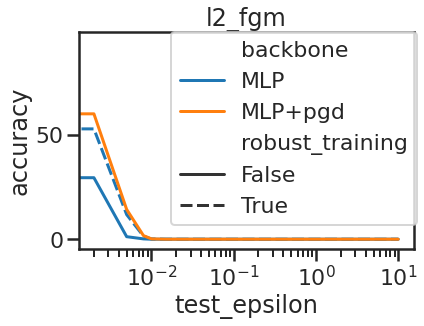

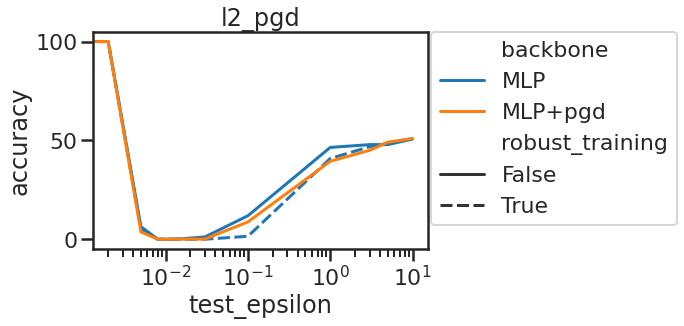

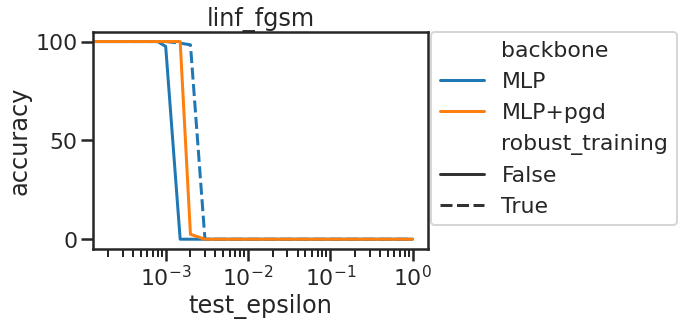

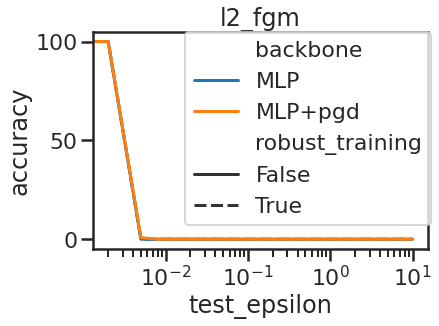

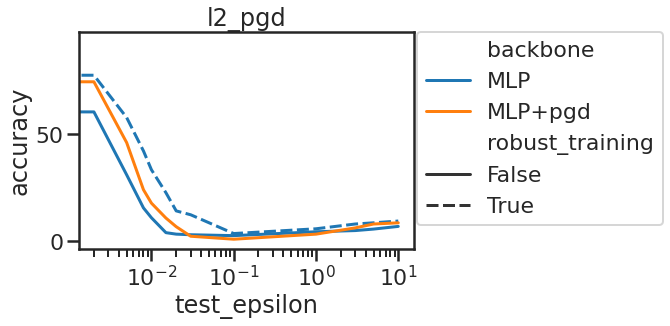

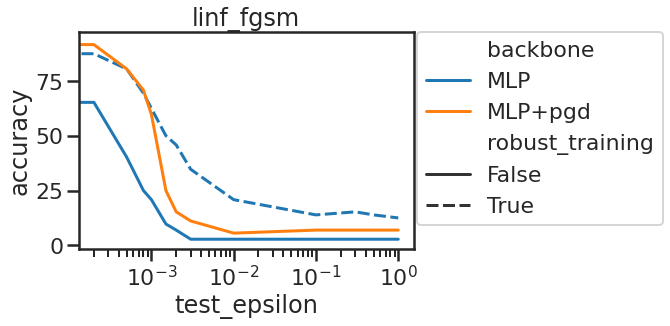

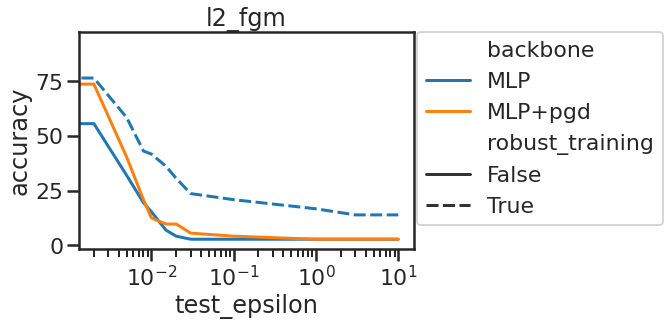

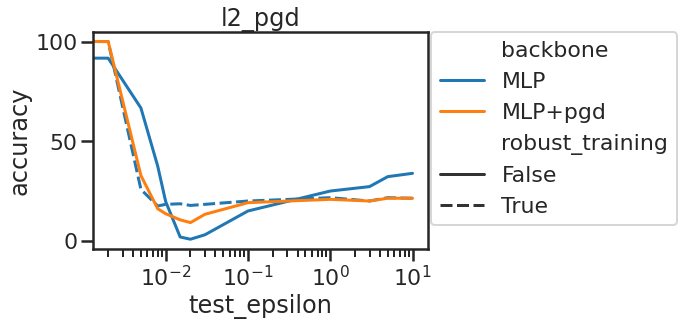

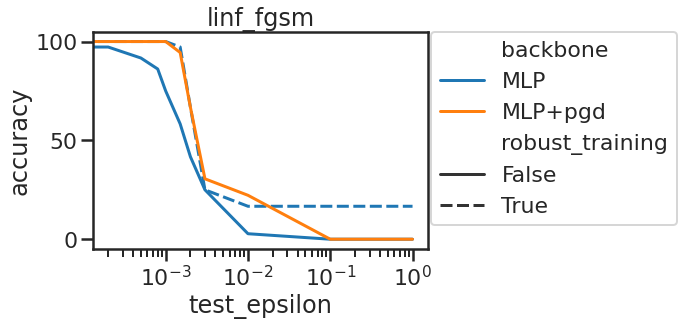

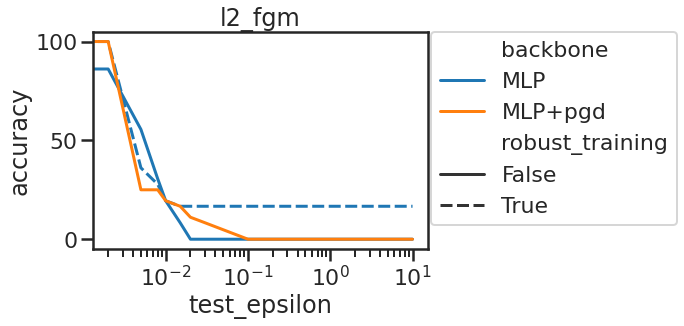

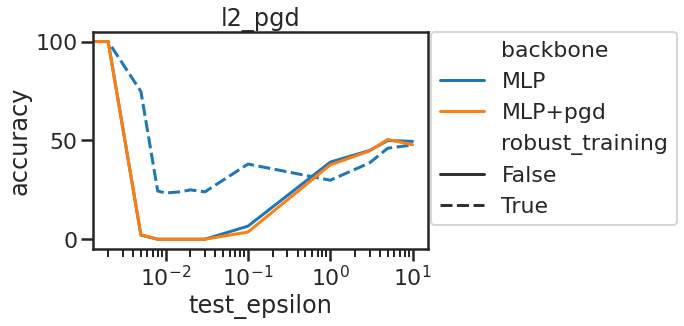

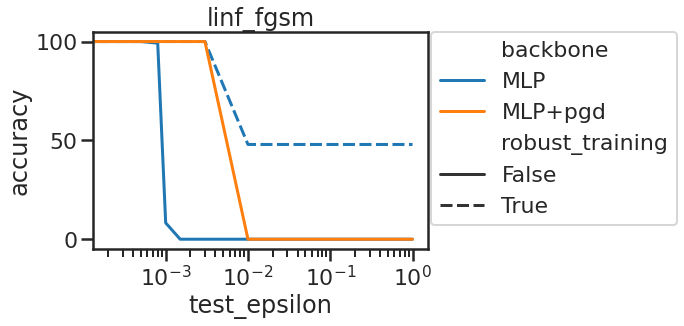

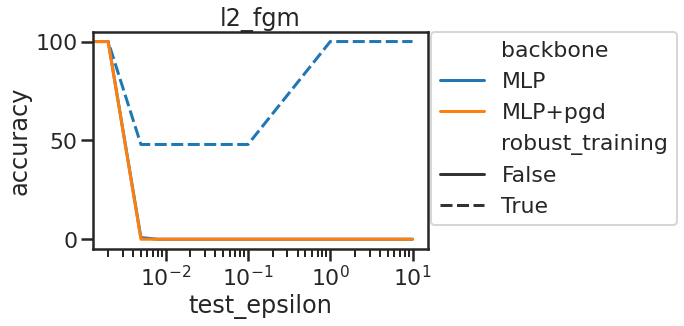

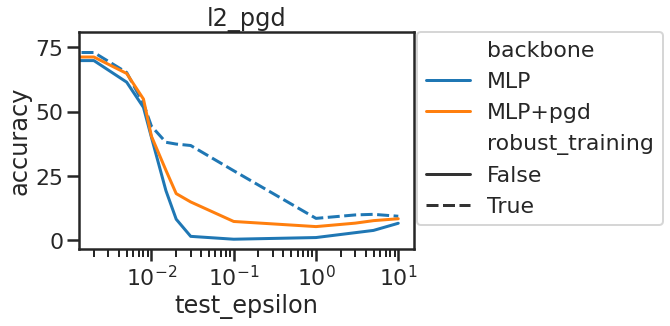

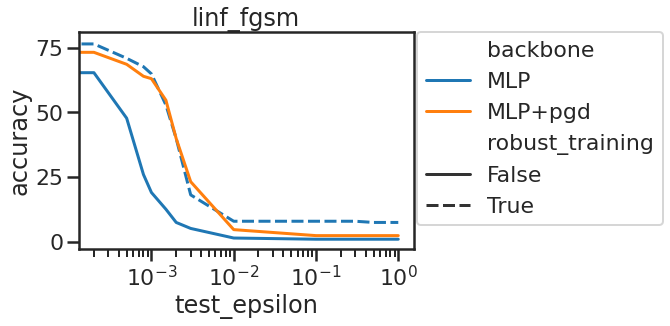

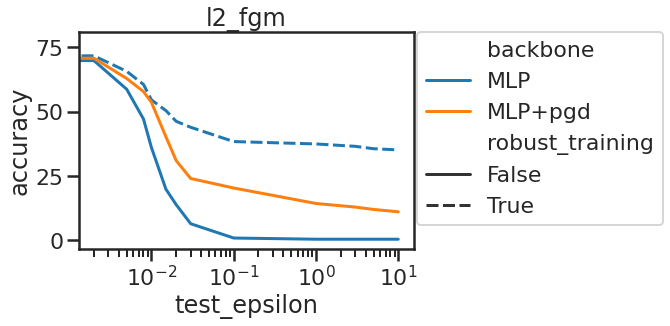

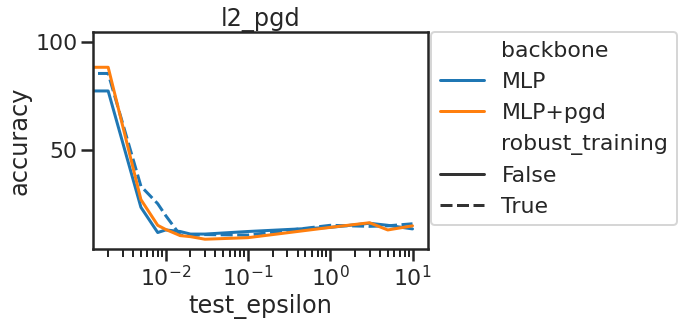

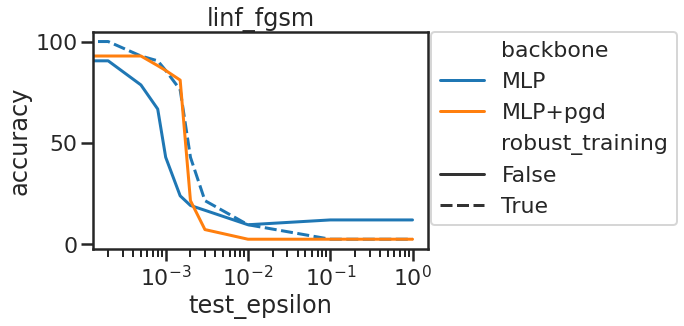

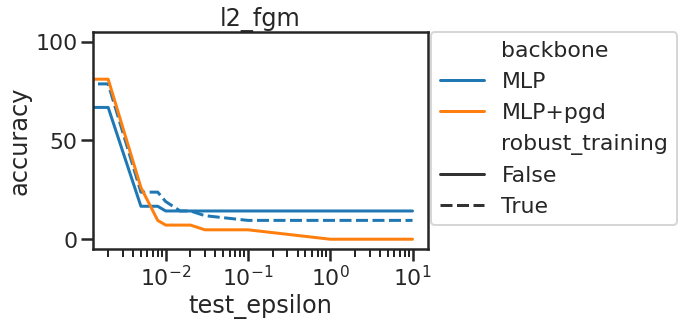

In [16]:
for dd in win_pgd + win_robust:
    for attack in name_attacks[1:]:
        plt.figure()
        sns.lineplot(x="test_epsilon", y="accuracy",
                     hue="backbone",  style='robust_training', palette="tab10",
                     data=df_results[(df_results.dataset==dd) & (df_results.attack==attack)]).set_title(attack)
        plt.xscale('log')
        plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

        ''' 
        plt.figure()
        epsilon = 0.1
        if attack == "l2_pgd" or attack == "l2_fgm" :
            epsilon = 1
        sns.catplot(x="backbone", y="accuracy",
                     hue="robust_training", col="test_epsilon", palette="tab10",kind="bar",
                     data=df_results[(df_results.test_epsilon == 0)| (df_results.test_epsilon == epsilon)][df_results.attack==attack])
        #plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
        '''
    ''' 
    plt.figure()
    sns.barplot(x="backbone", y="images_per_second",
                 hue="robust_training", palette="tab10",
                 data=df_results).set_title("time")
    plt.yscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    '''

In [54]:
dataset = 21+20

# Hash table of parameters
parameters = {"epsilon": {}, "backbone": {}, "initial_learning_rate": {}, 
              "robust_training": {}, "epsilon_pgd_training":{}}

to_exclude = []
experiment_list_tmp = [element for i, element in enumerate(experiment_list) if i not in to_exclude]
for exp in experiment_list_tmp:
    if not exp["data_set"]==dataset:
        continue
        
    for kk in parameters.keys():
        if exp[kk] in parameters[kk]:
            parameters[kk][exp[kk]].append(int(exp["model_name"]))
        else:
            parameters[kk][exp[kk]] = [int(exp["model_name"])]

for kk in parameters.keys():
    print(kk)
    print(list(parameters[kk].keys()))

epsilon
[0.1, 0.0001, 1e-05, 0.001, 0.01, 1]
backbone
['MLP', 'MLP+pgd']
initial_learning_rate
[0.1, 0.01, 0.001, 0.0001, 1e-05]
robust_training
[False, True]
epsilon_pgd_training
[0.1, 0.0001, 1e-05, 0.001, 0.01, 1]


[1365, 1366, 1367, 1368, 1369]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


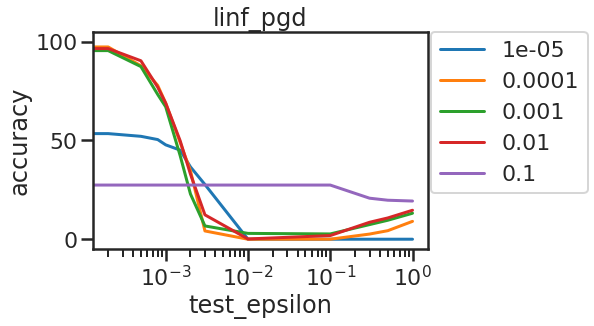

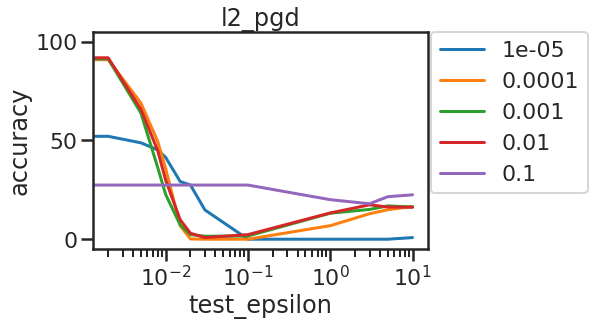

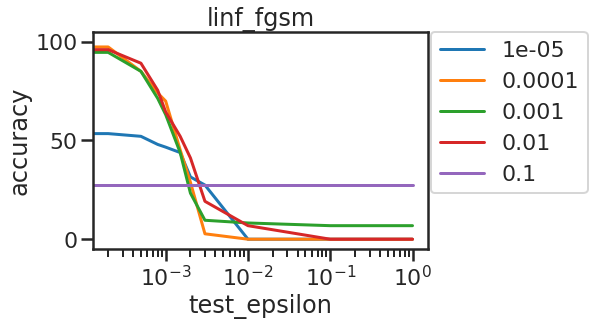

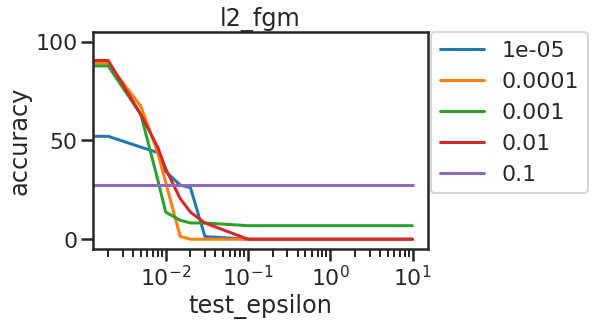

In [55]:
# Display learning rate impact
epsilon = 0.001
backbone = 'MLP'
robust_training = False
epsilon_pgd_training = 0.1

if robust_training:
    ids = list(set(parameters["backbone"][backbone]) & set(parameters["epsilon"][epsilon]) &
               set(parameters["robust_training"][robust_training]) 
               & set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))
else:
    ids = list(set(parameters["backbone"][backbone]) &
            set(parameters["robust_training"][robust_training]) & 
               set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))

print(ids)
list_entries = []
for id in ids:
    entry = {"learning_rate": experiment_list[id]['initial_learning_rate'],
            "backbone": experiment_list[id]['backbone'],
            "robust_training": experiment_list[id]['robust_training'],
            "epsilon": experiment_list[id]['epsilon']}
 
    for dataset in ["val", "test"]:
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)
            
            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                
df = pd.DataFrame.from_dict(list_entries) 
for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="learning_rate",  palette="tab10",
                 data=df[df.dataset=='test'][df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)


1408
1408
1408
1408
1408
1408


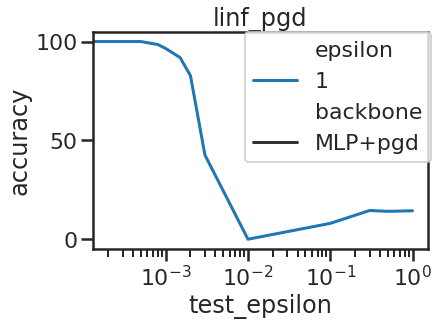

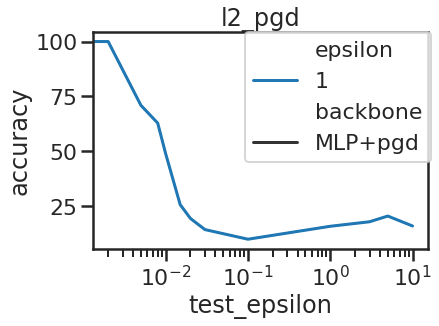

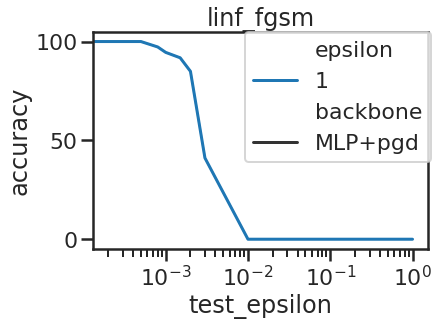

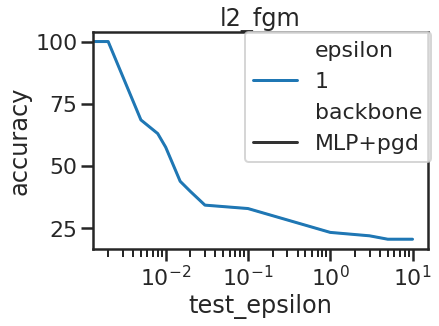

In [56]:
# Display epsilon
backbones = ['MLP+pgd']
robust_training = False
epsilon_pgd_training = 1e-3

list_entries = []
for backbone in backbones:
    for epsilon in list(parameters["epsilon"].keys()):

            
        if robust_training:
            ids = list(set(parameters["backbone"][backbone]) & set(parameters["epsilon"][epsilon]) &
                       set(parameters["robust_training"][robust_training])
                      & set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))
        else:
            ids = list(set(parameters["backbone"][backbone]) &
                    set(parameters["robust_training"][robust_training])
                      & set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))
            
        if len(ids)==0:
            continue
            
        # Cross-validation among learning rates:
        best_acc = 0.0
        best_id = -1
        for id in ids:
            acc = 0.0
            for attack in name_attacks:
                with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + 
                    attack + '.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                
                ave_acc = 0.0
                for test_epsilon in list(tmp.keys())[:2]:
                    ave_acc += tmp[test_epsilon]
                ave_acc = ave_acc / len(tmp.keys())
                acc += ave_acc
            acc = acc / 2
            if acc>best_acc:
                best_id = id
                best_acc = acc
                
        print(best_id)
        entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                "backbone": experiment_list[best_id]['backbone'],
                "robust_training": experiment_list[best_id]['robust_training'],
                "epsilon": experiment_list[best_id]['epsilon']}

        dataset = "test"
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)

            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                
df = pd.DataFrame.from_dict(list_entries) 

for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="epsilon",  style='backbone', palette="tab10",
                 data=df[df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)


[1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399]
1376
[1365, 1366, 1367, 1368, 1369]
1366
[1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407]
1408


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


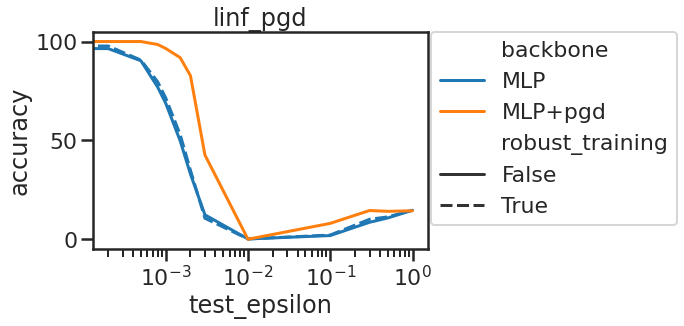

<Figure size 432x288 with 0 Axes>

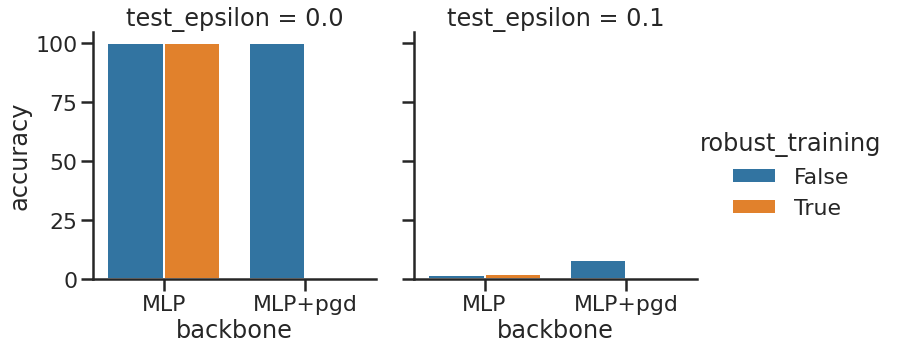

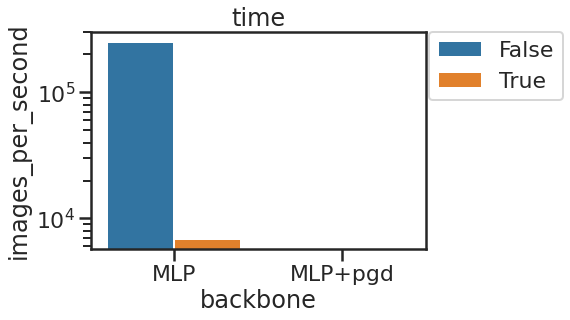

In [60]:
# Display best
backbones = ['MLP', 'MLP+pgd']
robust_trainings = [True,False]

list_entries = []
for backbone in backbones:
    for robust_training in robust_trainings:
        if (backbone == 'Madry' and robust_training == True) or \
            (backbone == 'CNN+clipping' and robust_training == False):
            continue
            
        ids = list(set(parameters["backbone"][backbone]) & set(parameters["robust_training"][robust_training]))
        
        if backbone == 'MLP+pgd' and robust_training == True:
            continue
            
        if ids == []:
            continue
        print(ids)
        
        # Cross-validation among learning rates:
        best_acc = 0.0
        best_id = -1
        for id in ids:
            #if (experiment_list[id]['backbone'] == 'CNN+pgd') and experiment_list[id]["epsilon_pgd_training"] == 0.3:
            #    continue 
            acc = 0.0
            for attack in [name_attacks[0]]:
                with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + 
                    attack + '.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                
                ave_acc = 0.0
                for test_epsilon in list(tmp.keys())[0:1]:
                    ave_acc += tmp[test_epsilon]
                ave_acc = ave_acc / len(tmp.keys())
                acc += ave_acc
            acc = acc / 2
            if acc>best_acc:
                best_id = id
                best_acc = acc

        entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                "backbone": experiment_list[best_id]['backbone'],
                "robust_training": experiment_list[best_id]['robust_training'],
                "epsilon": experiment_list[best_id]['epsilon']}

        dataset = "test"
        print(best_id)
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            
            if not backbone == 'Madry':
                with open(results_dir + experiment_list[best_id]['model_name'] + 
                          '/results/training_time.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                entry["images_per_second"] = np.mean(tmp) 
                entry["std_images_per_second"] = np.std(tmp) 
                
            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)

            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                  
df = pd.DataFrame.from_dict(list_entries) 

for attack in [name_attacks[0]]:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="backbone",  style='robust_training', palette="tab10",
                 data=df[df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

    plt.figure()
    epsilon = 0.1
    if attack == "l2_pgd" or attack == "l2_fgm" :
        epsilon = 1
    sns.catplot(x="backbone", y="accuracy",
                 hue="robust_training", col="test_epsilon", palette="tab10",kind="bar",
                 data=df[(df.test_epsilon == 0)| (df.test_epsilon == epsilon)][df.attack==attack])
    #plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

plt.figure()
sns.barplot(x="backbone", y="images_per_second",
             hue="robust_training", palette="tab10",
             data=df).set_title("time")
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

In [ ]:
df[(df.test_epsilon==0.01)&(df.attack=='linf_pgd')]

In [87]:
df[df.backbone=="Madry"][df.attack=="linf_pgd"][df.test_epsilon == 0.3 ]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,learning_rate,backbone,robust_training,epsilon,dataset,attack,test_epsilon,accuracy,images_per_second,std_images_per_second
218,0.001,Madry,True,0.1,test,linf_pgd,0.3,93.515625,NaN,NaN
270,0.001,Madry,True,0.1,test,linf_pgd,0.3,93.515625,NaN,NaN


In [107]:
df[df.backbone=="Madry"][df.attack=="linf_fgsm"][df.test_epsilon == 0.3 ]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,learning_rate,backbone,robust_training,epsilon,dataset,attack,test_epsilon,accuracy,images_per_second,std_images_per_second
244,0.001,Madry,True,0.1,test,linf_fgsm,0.3,95.507812,NaN,NaN
296,0.001,Madry,True,0.1,test,linf_fgsm,0.3,95.507812,NaN,NaN
